# Assignment #4 - Reinforcement Learning

### <font color="red"> DUE: Apr 16 (Tuesday) 11:00 pm </font>  

<font color="blue"> Narendra Kumar Vankayala </font>

# I. Overview

Describe the objective of this assignment. You can briefly state how you accompilsh it.

* In this Assignment, I will be applying Reinforcement Learning to BlackJack Problem, Problem description can be found below
* I will also discuss what is Q-Learning and how it can be play a major rule in Reinforcement Learning
* To learn what is a state, action, environment and how it can be applied to BlackJack Problem
* The goal of the BlackJack is to win the games against the agent
* I implemented a blackjackagent which will learn about the states and action and choses the best action for a particular state after certain number of iterations following Q-learning algorithm

# II. Problems 



## Blackjack

<img src="https://upload.wikimedia.org/wikipedia/commons/a/a2/Blackjack_game_1.JPG" width=800 />

Now, we play Blackjack! 
We have improved version of it from OpenAI Gym [Blackjack-V0](https://gym.openai.com/envs/Blackjack-v0/). Our blackjack has an additional betting option. Here follows the rule description. 


### <font color="red"> Game Introduction and Rules: </font>


Blackjack is a card game where the goal is to obtain cards that sum to as
near as possible to 21 without going over.  They're playing against a fixed
dealer.

Face cards (Jack, Queen, King) have point value 10.
Aces can either count as 11 or 1, and it's called 'usable' at 11.
This game is placed with an infinite deck (or with replacement).

The game starts with each player getting two face up cards and dealer
having one face up and face down card and the player needs to bet an 
amount of money within range of 1 to max bet (10). 
Note: Face up means that you will know what the card is.

The player can request additional cards (hit=1) until they decide to stop
(stick=0) or exceed 21 (bust).

After the player sticks, the dealer reveals their facedown card, and draws
until their sum is 17 or greater (fixed policy).  If the dealer goes bust the player wins.
You won't see the dealer's facedown card, just you will know if you have or lost
and you will get appropriate reward of +1 if you win, -1 if you loose or 0 if the match
is drawn.
(It is freedom of choice for you to change the reward function. If you want to change, you should explain the reason of the change.)

If the player wins, the amount he has bet will be doubled and given back. 
If the player and dealer have the same sum, then its a draw and the player will get
back the money he has bet. 
If the player loses then, the money he bet will be lost. 
If neither player nor dealer busts, the outcome (win, lose, draw) is
decided by whose sum is closer to 21. You are free to change the reward function to make it 
learn more efficiently. (i.e.,  the amount of money the user is winning after each round). 

Regardless of the number of players on the table, each player will be just playing against the 
dealer independently of the other players.

## BlackJack Environment

In [45]:
import collections
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from gym.utils import seeding
%matplotlib inline

### Player class definition

Player class defines an object for each BlackJack player with a given *unique* name. It has three attributes, the player's name, current cards in hand, and total balance left to play games.  <code>get_info()</code> is getter method that prints out all three attributes.

In [46]:
class Player():
    """
        
        Player class to create a player object.
        eg: player = Player("player1", start_balance = 10)
        Above declaration will be for your agent.
        All the player names should be unique or else you will get error.
        
    """
    def __init__(self, player_name, start_balance = 10):
        self.player_name = player_name
        self.card = []
        self.starter_balance = start_balance
        self.total_balance = start_balance

    def recharge_account(self):
        self.total_balance = self.starter_balance
        
    def get_info(self):
        print("Player name: {}".format(self.player_name))
        print("Player card: {}".format(self.card))
        print("Player total_balance: {}".format(self.total_balance))     

Following functions are utilities and definition of card deck to play games and to check the game status. 

In [47]:
# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

def cmp(a, b):
    return float(a > b) - float(a < b)

def draw_card(np_random):
    return int(np_random.choice(deck))

def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

### Game Environment

The Blackjack game environment is defined as follows. Inheriting, OpenAI.Gym.Env, it overrides the interfances to enable the interfaction with the same interfaces with other OpenAI Gym environments. 

These are important member functions to be used by you:
1. add_player: You can add your player object with some initial amount of money

2. step: you need to send the action using this function, actions are hit(1) or stand(0)
        returns {'state': player info and dealer info (_get_obs), 
                 'reward': real-valued reward, 
                 'is_round_done': True/Fasle}
3. _get_obs: returns the state of the env or required information you can use to build your agent. 
             eg: {'player_info':{'player_sum_card': sum of cards, 
                                 'player_card': list of cards, 
                                 'player_total_balance': real-valued number, 
                                 'usable_ace' : True/False}, 
                 'dealer_info': dealer's first card}
4. init_round: will start a new round in the same game.
        returns {'state': player info and dealer info (_get_obs)}
          
5. reset: will reset the whole game and you will being again with the initial balance you had started the player object.
        returns nothing, will just reset the entire game.
          
6. bet_money: you can bet the amount using this method, takes in the money between (1, max_bet_cap). max_bet_cap is 10. 
        returns nothing.


In [90]:
class BlackjackEnv(gym.Env):
    """
    Simple blackjack environment
    
    Blackjack is a card game where the goal is to obtain cards that sum to as
    near as possible to 21 without going over.  They're playing against a fixed
    dealer.
    Face cards (Jack, Queen, King) have point value 10.
    Aces can either count as 11 or 1, and it's called 'usable' at 11.
    This game is placed with an infinite deck (or with replacement).
    The game starts with each (player and dealer) having one face up and one
    face down card.
    The player can request additional cards (hit=1) until they decide to stop
    (stick=0) or exceed 21 (bust).
    After the player sticks, the dealer reveals their facedown card, and draws
    until their sum is 17 or greater.  If the dealer goes bust the player wins.
    If neither player nor dealer busts, the outcome (win, lose, draw) is
    decided by whose sum is closer to 21.  The reward for winning is +1,
    drawing is 0, and losing is -1.
    The observation is: the players current sum, players current card, players balance left, 
    the dealer's one showing card (1-10 where 1 is ace),
    and whether or not the player holds a usable ace (0 or 1).
    
    Parameters
    ==========
    natural      boolean
                 option for 50% more reward on natural blackjack 
    
    """
    
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()
        self.total_players = 1
        self.players = {}
        self.natural = natural
        self.dealer = []
        self.round_bet_info = {}
        self.max_bet_cap = 10

    def add_player(self, player_class):
        if player_class not in self.players and len(self.players) < self.total_players:
            self.players[player_class.player_name] = player_class
        else:
            raise Exception("Maximum number of player allowed: {}. You can increase the player count while initializing the environment".format(len(self.players)))

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, player_name, action):
        assert self.action_space.contains(action)
        if action:  # hit: add a card to players hand and return
            self.players[player_name].card.append(draw_card(self.np_random))
            if is_bust(self.players[player_name].card):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.players[player_name].card), score(self.dealer))
            if self.natural and is_natural(self.players[player_name].card) and reward == 1:
                reward = 1.5
        if done:
            self.settle_balance(int(reward), player_name)
        return {'state':self._get_obs(player_name), 'reward': reward, 'is_round_done': done}

    def _get_obs(self, player_name):
        return {'player_info':self.get_player_obs(player_name), 
                'dealer_info': self.dealer[0]}

    def get_player_obs(self, player_name):
        return {'player_sum_card':sum_hand(self.players[player_name].card), 
                'player_card':self.players[player_name].card, 
                'player_total_balance':self.players[player_name].total_balance, 
                'usable_ace' : usable_ace(self.players[player_name].card)}
    
    def get_valid_bet_amount(self, player_name):
        print("player name: {} money left: {}".format(player_name, self.players[player_name].total_balance))
        if self.players[player_name].total_balance < 1:
            return {'is_round_done': True, 'valid_bet_amount': -1}
        max_bet_upper_limit = self.players[player_name].total_balance
        if self.players[player_name].total_balance >= self.max_bet_cap:
            max_bet_upper_limit = self.max_bet_cap            
        return {'is_round_done': False, 'valid_bet_amount': list(range(1, max_bet_upper_limit+1))}
            
    def init_round(self, player_name):         
        self.dealer = draw_hand(self.np_random)
        self.players[player_name].card = draw_hand(self.np_random)
        return {'state': self._get_obs(player_name)}        

    def bet_money(self, player_name, bet_amount):
        self.players[player_name].total_balance -= bet_amount
        self.round_bet_info[player_name] = bet_amount
            
    def settle_balance(self, is_winner, player_name):
        if is_winner == 1:
            print("player winner")
            self.players[player_name].total_balance += (2 * self.round_bet_info[player_name])
        elif is_winner == 0:
            print("Draw match")
            self.players[player_name].total_balance += self.round_bet_info[player_name]
        else:
            print("player loser, wont get back the money, try next round")
    
    def reset(self, natural=False):
        for player_name, player_class in self.players.items():
            player_class.recharge_account()
        self.natural = natural
        self.dealer = []
        self.round_bet_info = {}


### Example Run with Random Players

This following code shows how to create an environment and players to play 10 games with 20 maximum rounds. This only includes random betting and random hit/stick decision making. 

In [91]:
env = BlackjackEnv()
player1 = Player('player1')
env.add_player(player1)
#Number of games
number_of_games = 10

#Number of rounds
number_of_rounds = 20

for _game in range(number_of_games):

    env.reset()
    print("-"* 50)
    print("Game Number: {}".format(_game + 1))
    print("-"* 50)
    for _round in range(number_of_rounds): 
        print("%"* 50)
        print("Game Number: {} Round Number: {}".format(_game+1, _round+1))
        print("%"* 50)
        
        #Check if you have enough money left in the account to bet, if not break and start a new game
        valid_bet_flag = env.get_valid_bet_amount(player1.player_name)
        if valid_bet_flag['is_round_done']:
            print("You are out of money ! Will go to next game !!")
            break
        bet_amount = valid_bet_flag['valid_bet_amount']
        
        #Get the observations i.e state and use it to decide how much you want to bet
        round_obs = env.init_round(player1.player_name)
        print("Initial state: {}".format(round_obs))  
        
        # If you have just $1 left in the bank, you have no choice but to bet that amount 
        # and hopefully leave it to the fate for your agent to win and continue playing or just
        # start a new game
        if len(bet_amount) == 1 and bet_amount[0] == 1:
            print("You can only bet 1. So betting only 1.")
            random_bet = 1
        else:
            random_bet = np.random.choice(bet_amount)
        print("Random Init Bet: {}".format(random_bet))
        env.bet_money(player1.player_name, random_bet)
          
        
        # Look at the state and take actions, here the actions are selected randomly
        # you can use the agent to select the action
        random_action = np.random.randint(0, 2)
        print("Action taken: {}".format(random_action))

        #Use the selected action to actually take the action in env by calling step
        round_obs = env.step(player1.player_name, random_action)
        print("State after 1st action: {}".format(round_obs))

        #Check if the game is not over, if your action is stand then the game is over, else
        #the game continues in this loop until your action is stand
        while not round_obs['is_round_done']:
            #Select an random action and take the action
            random_action = np.random.randint(0, 2)
            print("Action taken: {}".format(random_action))
            round_obs = env.step(player1.player_name, random_action)
            print("State after nth action: {}".format(round_obs))

        #Round over, but the game will continue untill you have exhausted your initial money 
        print("Balance Left: {}".format(round_obs['state']['player_info']['player_total_balance']))
        print("Round over")
        print("-%-"*30)
        if (_round + 1) == (number_of_rounds):
            print("Max number of rounds played. If you see this message, you are the winner.")

--------------------------------------------------
Game Number: 1
--------------------------------------------------
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Game Number: 1 Round Number: 1
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
player name: player1 money left: 10
Initial state: {'state': {'player_info': {'player_sum_card': 14, 'player_card': [9, 5], 'player_total_balance': 10, 'usable_ace': False}, 'dealer_info': 6}}
Random Init Bet: 4
Action taken: 1
State after 1st action: {'state': {'player_info': {'player_sum_card': 17, 'player_card': [9, 5, 3], 'player_total_balance': 6, 'usable_ace': False}, 'dealer_info': 6}, 'reward': 0, 'is_round_done': False}
Action taken: 0
player winner
State after nth action: {'state': {'player_info': {'player_sum_card': 17, 'player_card': [9, 5, 3], 'player_total_balance': 14, 'usable_ace': False}, 'dealer_info': 6}, 'reward': 1.0, 'is_round_done': True}
Balance Left: 14
Round over
-%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--%--

# III. Methods

- Decide your TD learning approach: SARSA or Q-learning? 

* As the number of states increases, the memory required also increases exponentially. So the TD (Temporal Learning) considers that the agent knows only partial information with Markov Decision Processes. With only current and next state transition and without any model transition probability, TD lets the agent explore the environment to examine the random policy. 
With an estiate of the value function $V(s)$, $\hat{V}(s)$, 

   $$ 
        \begin{align}
        V(s_t) &= R_{t+1} + \gamma V(s_{t+1}) \\
        V(s_t) &\sim R_{t+1} + \gamma \hat{V}(s_{t+1}) \\
        \Rightarrow \quad \delta_t &= R_{t+1} + \gamma \hat{V}(s_{t+1}) - V(s_t).
        \end{align}
    $$
    
Here, $\delta$ represents the *temporal diffrence error*. 
We can use this error as a gradient to update the value estimation.

$$
    \begin{align}
        V(s_t) &\leftarrow R_{t+1} + \alpha \delta_t \\
        V(s_t) &\leftarrow R_{t+1} + \alpha (R_{t+1} + \gamma \hat{V}(s_{t+1}) - V(s_t))
    \end{align}
$$



## SARSA



Updation of Q values plays a key role in the reinforcement learning. In SARSA We update the Q values with assumption that we follow a certain behaviour policy. This is also called an on policy control. The updation rule is as follows:
$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)) 
$$

**[Algorithm: SARSA]**
![](http://incompleteideas.net/book/ebook/pseudotmp8.png)


## Q Learning

* Updation of Q values with out making an assumption and exploring other possible policies is called off-line policy control. or also called as Q learning.

$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)) 
$$**[Algorithm: Q-learning]**
![](http://incompleteideas.net/book/ebook/pseudotmp9.png)




- Decide your function approximator.
- Describe your approach and the reason why you select it.
- Finish epsilon_greedy function and other TODOs. Explain it.
- Explain your codes.

## Choice of Function Approximation and Reason

* BlackjackAgent I have choses 32 states, as we have for every sum of the card  one state and action as 2 since I am implementing only hit and stand actions
* For sum of 1 - 21 the states are 21 and and them maximum we get when we are at 20 is if we pick jack/queen/king we might get the sum as 30 so I have chosen 32 states for checking the invalid state also


## Approach and Selection of Algorithm

* Both Q learning and SARSA will learn optimal policy
* In Q-learning,we will start with random values and has the ability to explore the states based on the results and then update Q values. So as we keep finding the better approach we update the Q values 
* In SARSA, we will know the start policy and explore all the states and actions and update the Q values based on our policy
* Q learning is also good for lesser states as it converges earlier
* so I have chosen Q learning for implemneting the algorithm
* Epsilon Greed function is chosen as to balance exploration and exploitation as in the initial we want to explore because we are not aware of all the states and actions and rewards as we update the Q table we will be able to use the Q table to maximize our probability so we change the epsilon to do exploitation after some threshold
* It also gives us fast convergence

## Explanation of Codes

* I have defined a BlackjackAgent class 
* set_evn() is used for resetting environment after every game played
* epsilon_greed() is used to change the epsilon as we change from exploration to exploitation
* Train function is the core method where we first assign random action as we don't know in the initial stage. 
* I have chosen 2 states and 32 actions where two states are hit and stand
* play() method is used for testing which is playing the game with dealer

## RLAgent for Blackjack

In [152]:
import time
class BlackjackAgent:
    
    def set_env(self):
        blackjackenv = BlackjackEnv(natural=False)
        player1 = Player(player_name='D1')
        player2 = Player(player_name='P1')
        self.player1 = player1
        blackjackenv.add_player(player1)
        return blackjackenv
    
    def __init__(self):
        self.env = self.set_env()
        self.Q = np.zeros((32,2))
        
    def epsilon_greed(self, epsilon, s):
        action = [0, 1]
        if np.random.rand() < epsilon:
            return np.random.randint(len(action))
        else:
            return np.argmax(self.Q[s['player_sum_card']][action])
        
    def train(self, **params):
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon = params.pop('epsilon', 0.1)
        maxiter = params.pop('maxiter', 1000)
        sarsa = params.pop('sarsa', False)
        edecay = params.pop('edecay', None)
        rtrace = []
        for i in range(maxiter):
            if i ==2000:
                time.sleep(5)
            self.env = self.set_env()
            if edecay is not None:
                epsilon = max(0.1, epsilon * edecay)
            valid_bet_flag = self.env.get_valid_bet_amount(self.player1.player_name)
            if valid_bet_flag['is_round_done']:
                break
            bet_amount = valid_bet_flag['valid_bet_amount']
            round_obs = self.env.init_round(self.player1.player_name)
            if len(bet_amount) == 1 and bet_amount[0] == 1:
                random_bet = 1
            else:
                random_bet = np.random.choice(bet_amount)
            self.env.bet_money(self.player1.player_name, random_bet)
            random_action = np.random.randint(0, 2)
            res = self.env.step(self.player1.player_name, random_action)
            rewards = []
            while not res['is_round_done']:
                f = 0 
                s = self.env.get_player_obs(self.player1.player_name)
                a = self.epsilon_greed(epsilon, s)
                va = [0, 1]
                res = self.env.step(self.player1.player_name, a)
                r = res['reward']
                rewards.append(r)
                print("1: ", rewards)
                if not res['is_round_done']:
                    f = 1
                    s1 = self.env.get_player_obs(self.player1.player_name)
                    a1 = self.epsilon_greed(epsilon, s1)
                    res = self.env.step(self.player1.player_name, a1)
                    r1 = res['reward']
                    rewards.append(r1)
                    print("2: ", rewards)
                s2 = self.env.get_player_obs(self.player1.player_name)
                self.Q[s['player_sum_card']][a] += alpha * (r + gamma * np.max(self.Q[s2['player_sum_card']][va]) - self.Q[s['player_sum_card']][a])
            self.env = self.set_env()
            rtrace.append(np.sum(rewards))
#             print(self.env.get_player_obs(self.player1.player_name))
        return rtrace
    
    def play(self):
        self.env = self.set_env()
        self.env.init_round(self.player1.player_name)
        f = 0
        while not f:
            print(self.env.get_player_obs(self.player1.player_name))
            s = self.env.get_player_obs(self.player1.player_name)
            valid_action = [0 , 1]
            a =  np.argmax(self.Q[s['player_sum_card']][valid_action])
            res = self.env.step(self.player1.player_name, a)
            f = res['is_round_done']
            if not f: 
                s = self.env.get_player_obs(self.player1.player_name)
                a = np.argmax(self.Q[s['player_sum_card']][valid_action])
                res = self.env.step(self.player1.player_name, a)
                f = res['is_round_done']
            print(res)
            print(self.env.get_player_obs(self.player1.player_name))
        

In [153]:
agent = BlackjackAgent()

In [154]:
agent.train(maxiter = 1000, edecay = 0.99, epsilon = 0.2, gamma = 0.8)

player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player win

player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: 

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player na

player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
play

player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 

player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player n

[1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 -1,
 0.0,
 1.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 0.0,
 -1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 -1,
 -1.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 1.0,
 0.0,
 0.0,
 -1,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 -1.0,
 0.0,
 0.0,
 -1,
 -1,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 1.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 -1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,

In [155]:
agent.Q

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.1       ,  0.        ],
       [ 0.        ,  0.02848313],
       [-0.1       ,  0.        ],
       [-0.1       ,  0.06262862],
       [-0.1       ,  0.05806967],
       [-0.198     , -0.09267166],
       [-0.10760345, -0.1       ],
       [-0.3407717 , -0.08923564],
       [-0.36263656, -0.37850186],
       [-0.63833204, -0.49547048],
       [-0.38691644, -0.46548138],
       [-0.34130955, -0.57828867],
       [ 0.44537037, -0.33661   ],
       [ 1.12468035, -0.3439    ],
       [ 2.60408942, -0.19      ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,

In [156]:
agent.play()

{'player_sum_card': 9, 'player_card': [7, 2], 'player_total_balance': 10, 'usable_ace': False}
player loser, wont get back the money, try next round
{'state': {'player_info': {'player_sum_card': 17, 'player_card': [7, 2, 8], 'player_total_balance': 10, 'usable_ace': False}, 'dealer_info': 10}, 'reward': -1.0, 'is_round_done': True}
{'player_sum_card': 17, 'player_card': [7, 2, 8], 'player_total_balance': 10, 'usable_ace': False}


# IV - Results

- Describe the choice of your parameters for $\gamma$, $\alpha$, and $\epsilon$. 
  - Run experiments to find good parameters
  - Show the experimental outputs to show the process of your selection
- Visualize the results and explain outputs (even from mine.)
  - Run the codes and tell me what you observe
  - Add more visualizations to enrich your explanation.

## Running Experiments for gamma, alpha and epsilon

In [110]:
player1 = BlackjackAgent()

In [111]:
player1.train(maxiter = 1200, edecay = 0.8, epsilon = 0.8, gamma = 0.9)

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 m

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 1

1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 mone

player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
2:  [0, 0]
player winner
1:  [0, 0, 1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, w

player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player 

player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont 

[0.0,
 -1.0,
 1.0,
 -1.0,
 0.0,
 1.0,
 0.0,
 -1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 -1,
 0.0,
 0.0,
 -1,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 -1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 -1,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 0.0,

In [112]:
player1.Q

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.1       ,  0.        ],
       [-0.17992606,  0.11193266],
       [-0.1       ,  0.18520251],
       [-0.1       ,  0.44321457],
       [-0.1       ,  0.04854283],
       [-0.36723976, -0.07299268],
       [-0.58362651, -0.20485306],
       [-0.56243212,  0.16747234],
       [-0.2960397 , -0.13955914],
       [-0.33617928, -0.29723866],
       [ 0.02160445, -0.271     ],
       [ 1.08249757, -0.40951   ],
       [ 1.31275606, -0.19      ],
       [ 3.19693144, -0.1       ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,

In [113]:
player1.play()

{'player_sum_card': 12, 'player_card': [2, 10], 'player_total_balance': 10, 'usable_ace': False}
player loser, wont get back the money, try next round
{'state': {'player_info': {'player_sum_card': 25, 'player_card': [2, 10, 3, 10], 'player_total_balance': 10, 'usable_ace': False}, 'dealer_info': 8}, 'reward': -1, 'is_round_done': True}
{'player_sum_card': 25, 'player_card': [2, 10, 3, 10], 'player_total_balance': 10, 'usable_ace': False}


In [102]:
player2 = BlackjackAgent()

In [105]:
player2.train(maxiter = 1500, edecay = 0.7, epsilon = 0.1, gamma = 0.98)

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 

player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
pla

player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
1:  [0]
2:  [0, 0]
player winner
1:  [0, 0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
p

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
play

1:  [1.0]
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
2:  [0, 0]
1:  [0, 0, 0]
player loser, wont get back the money, try next round
2:  [0, 0, 0, -1.0]
player name: D1 money left: 10
1:  [0]
2:  [0, 0]
Draw match
1:  [0, 0, 0.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
2:  [0, 0]
player winner
1:  [0, 0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
Draw match
player name: D1 mo

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: 

player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
Draw match
2:  [0, 0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 -1,
 1.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 1.0,
 0.0,
 -1.0,
 -1,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 -1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 0.0,
 0.0,
 -1.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 

In [107]:
player2.Q

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00],
       [-1.00000000e-01,  2.49740449e-02],
       [-1.00000000e-01,  2.65022781e-01],
       [-1.58881260e-01,  1.60720770e+00],
       [-1.00000000e-01,  1.38472920e+00],
       [-1.00000000e-03,  1.70985913e+00],
       [-1.22161165e-01,  5.24994558e-01],
       [-4.12554601e-01,  4.50455305e-01],
       [-4.57701670e-01,  4.66196063e-01],
       [-5.59966704e-01,  1.07668565e+00],
       [-6.61345642e-01,  4.28206983e-01],
       [-6.44796729e-01, -5.80045345e-01],
       [ 2.41896465e-01, -3.87497485e-01],
       [ 3.64318982e+00,  3.03763837e-01],
       [ 4.76664460e+00, -5.21703100e-01],
       [ 1.01967458e+01, -1.59491133e-01],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.

In [106]:
player2.play()

{'player_sum_card': 14, 'player_card': [4, 10], 'player_total_balance': 10, 'usable_ace': False}
player loser, wont get back the money, try next round
{'state': {'player_info': {'player_sum_card': 24, 'player_card': [4, 10, 10], 'player_total_balance': 10, 'usable_ace': False}, 'dealer_info': 4}, 'reward': -1, 'is_round_done': True}
{'player_sum_card': 24, 'player_card': [4, 10, 10], 'player_total_balance': 10, 'usable_ace': False}


In [114]:
player3 = BlackjackAgent()

In [115]:
player3.train(maxiter = 10000, epsilon = 0.7, gamma  =0.7)

player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next roun

player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try ne

player winner
2:  [0, 1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, 

player winner
2:  [0, 1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
1:  [0]
Draw match
2:  [0, 0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont g

player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player loser, won

1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left:

player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
Draw match
2:  [0, 0.0]
playe

player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
2:  [0, 0]
player winner
1:  [0, 0, 1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 mo

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money l

player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
pla

1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next roun

player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
2:  [0, 0]
player loser, wont g

player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
p

player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next 

player name: D1 money left: 10
1:  [0]
2:  [0, 0]
player loser, wont get back the money, try next round
1:  [0, 0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next

player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back 

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money 

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser,

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
2:  [0, 0]
player loser, wont get back the money, try next round
1:  [0, 0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
Draw match
player na

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
p

player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 m

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player l

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player 

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 1

1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
1:  [0]
2:  [0, 0]
1:  [0, 0, 0]
player winner
2:  [0, 0, 0, 1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player na

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
1:

player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1

player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money lef

player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
Draw match
2:  [0, 0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get 

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser

player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player 

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 mo

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:

player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10


1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
play

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next r

player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wo

player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
pla

player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 mon

player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try n

player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player nam

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player l

1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try n

player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
pl

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser

1:  [0]
Draw match
2:  [0, 0.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player nam

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money 

player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the mon

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name:

player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get ba

player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
p

player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name:

1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont 

player winner
1:  [1.0]
player name: D1 money left: 10
1:  [0]
2:  [0, 0]
player loser, wont get back the money, try next round
1:  [0, 0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
1:  [0]
player loser, wont get b

player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 mo

[-1.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 1.0,
 1.0,
 -1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 -1,
 0.0,
 -1,
 0.0,
 1.0,
 1.0,
 0.0,
 -1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 -1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 1.0,
 0.0,
 0.0,
 -1,
 -1.0,
 -1.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 1.0,
 0.0,
 0.0,
 -1.0,
 -1,
 0.0,
 0.0,
 -1.0,
 -1.0,
 0.0,
 1.0,
 0.0,
 -1,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 -1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 -1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 -1,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1,
 1.0,
 0.0,
 0.0,
 -1.0,
 0.0,
 0

In [116]:
player3.Q

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [-0.1       ,  0.        ],
       [-0.14746868,  0.00401919],
       [-0.26603895, -0.02092766],
       [-0.3236097 ,  0.15032318],
       [ 0.03765434,  0.3560532 ],
       [-0.24749038,  0.60075092],
       [-0.390956  ,  0.15291913],
       [-0.471398  ,  0.0295318 ],
       [-0.55755704,  0.02637286],
       [-0.20181497, -0.34214158],
       [-0.56183553, -0.07009127],
       [-0.54275181, -0.46285559],
       [ 0.72537809, -0.8024475 ],
       [ 1.46833981, -0.74428694],
       [ 1.94888444, -0.60004902],
       [ 2.90839628, -0.48803569],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.        ,

In [118]:
player3.play()

{'player_sum_card': 14, 'player_card': [8, 6], 'player_total_balance': 10, 'usable_ace': False}
player loser, wont get back the money, try next round
{'state': {'player_info': {'player_sum_card': 24, 'player_card': [8, 6, 10], 'player_total_balance': 10, 'usable_ace': False}, 'dealer_info': 8}, 'reward': -1, 'is_round_done': True}
{'player_sum_card': 24, 'player_card': [8, 6, 10], 'player_total_balance': 10, 'usable_ace': False}


## Plots

In [120]:
rtrace1= player1.train(maxiter = 1200, edecay = 0.8, epsilon = 0.8, gamma = 0.9)

player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
pl

player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
Draw match
2:  [0, 0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner


player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player winner
player na

player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
2:  [0, 0]
player winner
1:  [0, 0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10

player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player 

player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [

Text(0, 0.5, 'Sum of Rewards')

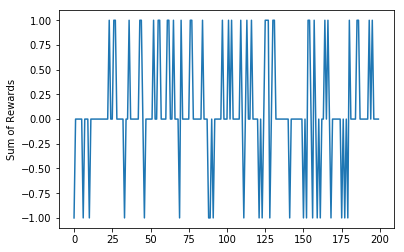

In [123]:
plt.plot(rtrace1[:200])
plt.ylabel("Sum of Rewards")

In [124]:
rtrace2  = player2.train(maxiter = 1500, edecay = 0.7, epsilon = 0.1, gamma = 0.98)

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1

player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 

1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
play

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wo

2:  [0, 1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winne

player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name:

player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get b

Text(0, 0.5, 'Sum of Rewards')

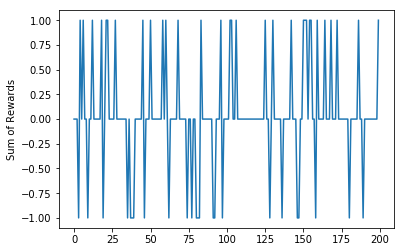

In [126]:
plt.plot(rtrace2[:200])
plt.ylabel("Sum of Rewards")

In [127]:
rtrace3 = player3.train(maxiter = 10000, epsilon = 0.7, gamma  =0.7)

player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next roun

player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
pl

player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player winner
player name: D1 money left: 10
Draw match
p

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, tr

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try 

player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
playe

player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try ne

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player lose

1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player los

player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player lo

player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
pl

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the mo

player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try 

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the 

player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try n

player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
2:  [0, 0]
1:  [0, 0, 0]
player winner
2:  [0, 0, 0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D

player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
1:  [0]
2:  [0, 0]
player loser, wont get back the money, try next round
1:  [0, 0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 1

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player

1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, tr

1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
Draw match
2:  [0, 0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
p

player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money 

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, 

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
2:  [0, 0]
player loser, wont get back the money, try next round
1:  [0, 0, -1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
1:  [0]
player loser, wont get back t

player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, 

1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
p

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
2:  [0, 0]
player loser, wont get back the money, try next round
1:  [0, 0, -1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the mon

player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the m

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money

player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next roun

player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try 

player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont g

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D

1:  [-1.0]
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next 

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get b

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player n

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]

1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player n

player name: D1 money left: 10
player winner
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round

player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
1:  [0]
Draw match
2:  [0, 0.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
1:  [1.0

player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the mon

player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next ro

player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next r

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back

1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
pla

player winner
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
1:  [0]
2:  [0, 0]
player loser, wont get back the money, try next round
1:  [0, 0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try ne

1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player l

player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10


player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
pl

player winner
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
1:  [0]
2:  [0, 0]
player loser, wont get back the money, try next round
1:  [0, 0, -1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
playe

player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
player name: D1 money left: 10
player loser, wont get back the money, try next round
player 

player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
1:  [0]
player winner
2:  [0, 1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
1:  [0]
player loser, wont get back the money, try next round
2:  [0, -1.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get ba

2:  [0, 1.0]
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1]
player name: D1 money left: 10
Draw match
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
Draw match
1:  [0.0]
player name: D1 money left: 10
player loser, wont get back the money, try next round
player name: D1 money left: 10
player loser, wont get back the money, try next round
1:  [-1.0]
player name: D1 money left: 10
player winner
1:  [1.0]
player name: D1 money left: 10
player winner

Text(0, 0.5, 'Sum of Rewards')

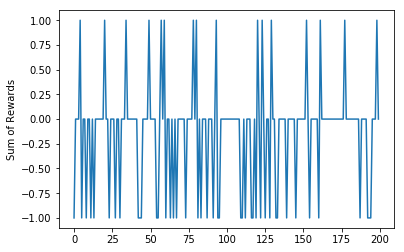

In [128]:
plt.plot(rtrace3[:200])
plt.ylabel("Sum of Rewards")

Text(0, 0.5, 'q values for hit and stand')

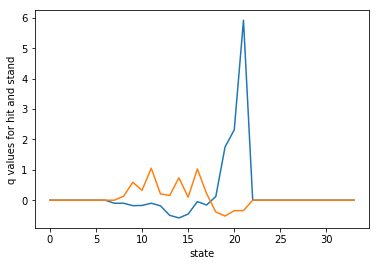

In [161]:
plt.plot(player1.Q[:])
plt.xlabel("state")
plt.ylabel("q values for hit and stand")

Text(0, 0.5, 'q values for hit and stand')

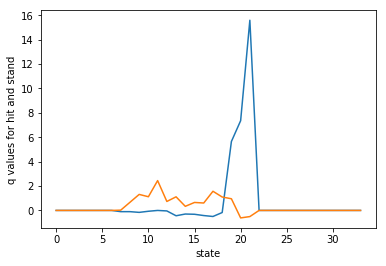

In [160]:
plt.plot(player2.Q)
plt.xlabel("state")
plt.ylabel("q values for hit and stand")

Text(0, 0.5, 'q values for hit and stand')

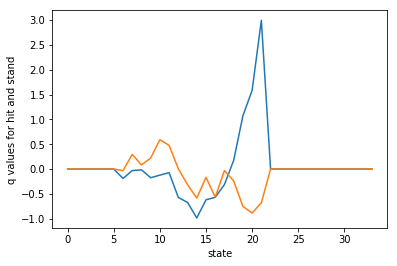

In [159]:
plt.plot(player3.Q)
plt.xlabel("state")
plt.ylabel("q values for hit and stand")

## Report parameters

* From the graph 2 we see that the probabilites or Q values are higher for our required output  so the good set of params are alpha = 0.7, epsilon = 0.1, gamma = 0.98
* The number of iterations is also a factor but here the number of iterations are 1500 so if we change the set of good params might also change
* if the epsilon value is less, the agent will not exploit the Q table and goes into same action sequence everytime once it finds the best sequence
* so the optimal value should be around 0.7 after we reach some good amount of iterations
* maxiter has to substantially large as the agent will not learn any thing in the begining due to the random state and not able to explore all the possibilities. 


# V. Conclusions

* I learnt about how to implement two important algorithms in Reinforcement Learning Q learning and SARSA
* This can be heavily attributed to implementation of RL agent. 
* Inferenced that the reinforcement learning is difficult to generalize as the actions and states are different for different games and situations
* Learnt how to chose tradeoff between explorationa and exploitation
* Learnt that as in a real world to simulate the reinforcement learning, it required lot of computational power as the number of states and action is varied 
* Policy function is not standard across all RL agents
 

# Extra Credit for Tournament Top16!

- In two classes, we will have qualification and tournament.
- In qualification game, individual will play against a dealer for one game for 50 round. 
  - Highly ranked (by the profit) and non-broke players will proceed to the tournament.
  - max. 32 players will be cut for main tournament.
- In tournament, 4 players will be play in each round.
  - In a table game, the game lasts until two players broke
  - In final, the game will ends in 50 rounds and winner will be the one with highest balance. 

## Grading

We will test your notebook with an additional grid.txt file. Please make sure to test in different maze input files. 

points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
35 | Methods | 
 |10| Review of the SARSA and Q-Learning
 | 5| Choice of TD learning and Reason
 | 5| Choice of Function Approximation and Reason
 |10| Implementation of the selected approach (RLAgent)
 | 5| explanation of the codes
45 | Results 
 |10| Reports the selected parameters 
 |15| Experimental outputs that show the choice of parameters. How do you choose them?
 |10| Output plots (5 for each)
 |10| reading and analysis of learning results and plots
10 | Participation to the tournament.
5 | Conclusions 
